## Which type of data is the best fit for Lagrange Polynomial

Data with obvious peek(s) where it changes from increasing function to decreasing functions, or in reverse.

## Case study: Free Fall Experimental Data

Suppose we have experimental data from physicists, who collected the distance at different times, and the experiments repeat 5 times to ensure the trustworthy, as follows:

In [2]:
experiment::Matrix{Float64} = [  # (time, distance)
    0.00 0.0; 0.00 0.0; 0.00 0.0; 0.00 0.0; 0.00 0.0;
    0.50 1.0; 0.50 1.4; 0.50 1.1; 0.50 1.4; 0.50 1.5;
    0.75 2.6; 0.75 3.2; 0.75 2.8; 0.75 2.5; 0.75 3.1;
    1.00 4.8; 1.00 4.4; 1.00 5.1; 1.00 4.7; 1.00 4.8;
    1.25 8.2; 1.25 7.9; 1.25 7.5; 1.25 8.1; 1.25 7.4;
]

25×2 Matrix{Float64}:
 0.0   0.0
 0.0   0.0
 0.0   0.0
 0.0   0.0
 0.0   0.0
 0.5   1.0
 0.5   1.4
 0.5   1.1
 0.5   1.4
 0.5   1.5
 0.75  2.6
 0.75  3.2
 0.75  2.8
 0.75  2.5
 0.75  3.1
 1.0   4.8
 1.0   4.4
 1.0   5.1
 1.0   4.7
 1.0   4.8
 1.25  8.2
 1.25  7.9
 1.25  7.5
 1.25  8.1
 1.25  7.4

The data looks like this.

In [3]:
using Plots

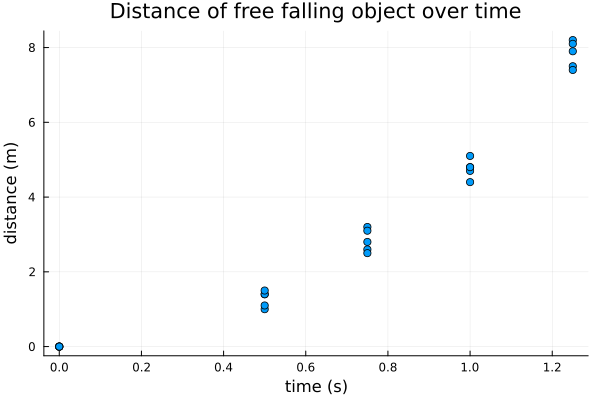

In [4]:
scatter(
    experiment[:, 1],
    experiment[:, 2],
    xlabel="time (s)",
    ylabel="distance (m)",
    title="Distance of free falling object over time",
    label=nothing,
)

From the graph, we can create the Lagrange polynomial out of the experimental data, where we have to pick a proper points that represents the overall; the average.

And since the data only increasing in a polaboric manner, ***only 3 points are necessary*** to build **a polynomial with degree 2**.

In [5]:
using Statistics

In [6]:
average_points::Dict{Float64, Float64} = Dict(
    0.0 => mean(experiment[1:5, 2]),
    0.75 => mean(experiment[11:15, 2]),
    1.25 => mean(experiment[21:25, 2]),
)

Dict{Float64, Float64} with 3 entries:
  0.0  => 0.0
  1.25 => 7.82
  0.75 => 2.84

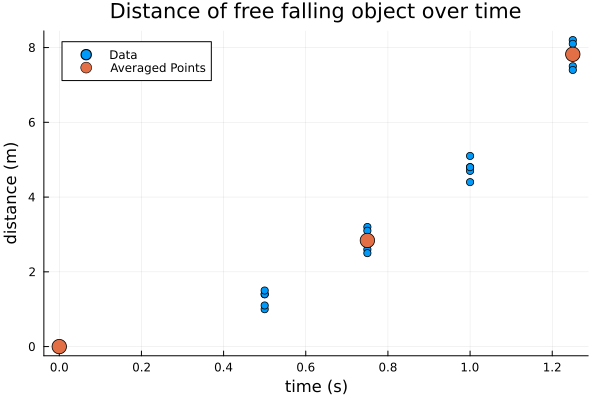

In [7]:
scatter(
    experiment[:, 1],
    experiment[:, 2],
    xlabel="time (s)",
    ylabel="distance (m)",
    title="Distance of free falling object over time",
    label="Data",
)
scatter!(
    average_points,
    label="Averaged Points",
    markersize=8,
)

## Implement Lagrange Polynomials

Use my own OOP-based Polynomial and Lagrange implementation to interpolate the data.

In [8]:
using Printf
using LaTeXStrings

Polynomial::Type{Dict{Int64, Float64}} = Dict{Int64, Float64}
# Dict of coefficient, followed by exponent

function addToPolynomial!(
        poly::Polynomial,
        expo::Int64,
        coef::Float64,
    )::Nothing
    
    poly[expo] = get(poly, expo, 0.0) + coef
    
    # this code reduces calculation overhead from zero terms
    # iszero(x) is specifically made for floating-point numbers
    if iszero(poly[expo]) 
        delete!(poly, expo)
    end
    
    return nothing
end

function addMultipleToPolynomial!(
        poly::Polynomial,
        monos::Union{Vector{Pair{Int64, Float64}}, Polynomial},
    )::Nothing
    for (expo, coef) in monos
        addToPolynomial!(poly, expo, coef)
    end
    return nothing
end

function calcPoly(poly::Polynomial, x::Float64)::Float64
    ret::Float64 = 0.0
    for (expo, coef) in poly
        ret += coef * x ^ expo
    end
    return ret
end

function polyPlus(p1::Polynomial, p2::Polynomial)::Polynomial
    ret::Polynomial = copy(p1)
    addMultipleToPolynomial!(ret, p2)
    
    return ret
end

function negPoly(poly::Polynomial)::Polynomial
    ret::Polynomial = copy(poly)
    for (expo, coef) in ret
        ret[expo] = -coef
    end
    
    return ret
end

function polyMinus(p1::Polynomial, p2::Polynomial)::Polynomial
    ret::Polynomial = copy(p1)
    neg_p2 = negPoly(p2)
    addMultipleToPolynomial!(ret, neg_p2)
    
    return ret
end

function polyMul(p1::Polynomial, p2::Polynomial)::Polynomial
    ret::Polynomial = Polynomial(Dict())
    for (expo1, coef1) in p1
        for (expo2, coef2) in p2
            addToPolynomial!(ret, expo1 + expo2, coef1 * coef2)
        end
    end
    
    return ret
end

function mulConstToPoly(poly::Polynomial, c::Float64)::Polynomial
    # @printf("Before: ")
    # println(printPoly(poly))
    ret::Polynomial = copy(poly)
    for (expo, coef) in ret
        ret[expo] = c * coef
    end
    
    # @printf("After: ")
    # println(printPoly(ret))
    
    return ret
end

function L(Xs::Vector{Float64}, j::Int64)::Polynomial
    xj::Float64 = Xs[j]
    ret::Polynomial = Polynomial(Dict(0 => 1.0))  # initial P(x) = 1x^0 = 1
    denom::Float64 = 1.0
    
    # println("Building L$j: x_%j = $xj")
    
    for (i, x) in enumerate(Xs)
        if i == j
            continue
        end
        
        current::Polynomial = Polynomial(Dict(1 => 1.0, 0 => -x))
        ret = polyMul(ret, current)
        denom::Float64 *= xj - x
    end
    
    ret = mulConstToPoly(ret, 1.0/denom)
    # println(printPoly(ret))
    return ret
end

function buildLagrange(data::Dict{Float64, Float64})::Polynomial  # takes pairs of (x, y) where x must be distinct
    Xs::Vector{Float64} = sort(collect(keys(data)))
    ret::Polynomial = Polynomial(Dict())
    for (i, x) in enumerate(Xs)
        l::Polynomial = L(Xs, i)
        term::Polynomial = mulConstToPoly(l, data[x])
        # println("data[$x] = $(data[x])")
        # println("multiplied term: $(printPoly(term))")
        ret = polyPlus(ret, term)
    end
    
    return ret
end

function printRawPoly(poly::Polynomial)::String
    txt::String = ""
    for (i, expo) in enumerate(sort(collect(keys(poly)), rev=true))
        if i > 1 && poly[expo] >= 0
            txt = string(txt, "+")
        end
        txt = string(txt, "$(poly[expo])")
        if expo > 0
            txt = string(txt, "x")
        end
        if expo > 1
            txt = string(txt, "^$expo")
        end
    end
    return txt
end

function printPoly(poly::Polynomial)::LaTeXString
    return LaTeXString("\$" * printRawPoly(poly) * "\$")
end

# to pass a polynomial, use <poly> in the format string
function printFormattedPoly(
        txt::String,
        polies::Vararg{Polynomial},
    )::LaTeXString
    for poly in polies
        txt = replace(txt, "<poly>" => printRawPoly(poly), count=1)
    end
    return LaTeXString("\$" * txt * "\$")
end

printFormattedPoly (generic function with 1 method)

## Build the Lagrange Model

Since we only need Lagrange polynomials of degree 2, we will build all possible combinations of 3 points instead of interpolate all 5 points at once, then average the result.

In [9]:
model::Polynomial = buildLagrange(average_points)
printFormattedPoly("\\mathrm{Q(x) = }<poly>", model)

L"$\mathrm{Q(x) = }4.938666666666666x^2+0.08266666666666467x$"

Plot to see the result.

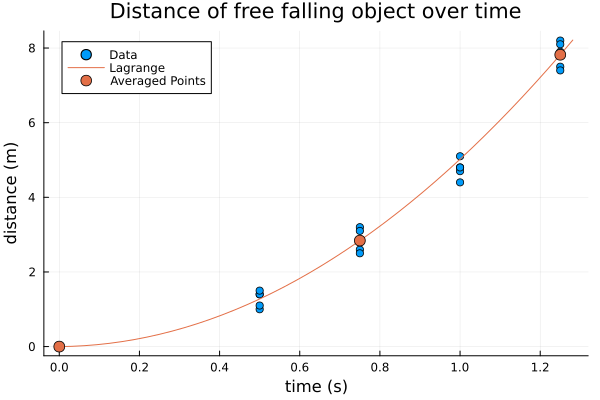

In [10]:
Xs = 0.0:0.03125:1.3
y_pred = [calcPoly(model, x) for x in Xs]

scatter(
    experiment[:, 1],
    experiment[:, 2],
    xlabel="time (s)",
    ylabel="distance (m)",
    title="Distance of free falling object over time",
    label="Data",
)
plot!(Xs, y_pred, label="Lagrange", color=2)
scatter!(
    average_points,
    label="Averaged Points",
    markersize=6,
    color=2,
)

## Further use case

Since we technically have a function of distance over time $y(t)$, it can be further derived into *speed* $v(t)$ and *accerelation* $a(t)$.

In [11]:
function derivativePoly(poly::Polynomial)::Polynomial
    ret::Polynomial = Polynomial(Dict())
    for (expo, coef) in poly
        if expo == 0
            continue
        end
        ret[expo - 1] = coef * expo
    end
    
    return ret
end

derivativePoly (generic function with 1 method)

The derivative of distance over time is ***speed***.

In [12]:
speed::Polynomial = derivativePoly(model)
printFormattedPoly("\\mathrm{v(x) = }<poly>", speed)

L"$\mathrm{v(x) = }9.877333333333333x+0.08266666666666467$"

And the derivative of speed over time is ***acceleration***.

In [13]:
accelerator::Polynomial = derivativePoly(speed)
printFormattedPoly("\\mathrm{a(x) = }<poly>", accelerator)

L"$\mathrm{a(x) = }9.877333333333333$"

Since we got a constant function, this is actually the $\mathrm{g}$ value -- the earth's gravitational acceleration. We can conclude from the experimental data that *the gravitational acceleration around the place that scientists collect data from is $\mathrm{g}=9.8773\text{ m/s}^2$*

Knowing the exect value of $\mathrm{g}$, we can further substitute this constant to any other experiments in the future, which is crucial for creditibility, reproducibility, and high numerical precision.